# Load Libraries

In [1]:
import os
import warnings
import logging
import sys
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import dotenv
import pyet

# Load environment variables from .env file
dotenv.load_dotenv()

# Set up logging
logging.basicConfig(level=logging.INFO)

# Suppress warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Load Data

In [2]:
# Load Data From Pickle
with open('../../data/Khorasan_Data_1950_2025.pkl', 'rb') as f:
    data = pickle.load(f)
    logging.info("Data loaded from pickle file.")

INFO:root:Data loaded from pickle file.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531359 entries, 0 to 531358
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   station_id         531359 non-null  category      
 1   station_name       531359 non-null  category      
 2   region_id          531359 non-null  category      
 3   region_name        531359 non-null  category      
 4   lat                531359 non-null  float64       
 5   lon                531359 non-null  float64       
 6   station_elevation  531359 non-null  float64       
 7   date               531359 non-null  datetime64[ns]
 8   tmax               522407 non-null  float64       
 9   tmin               511729 non-null  float64       
 10  tm                 506243 non-null  float64       
 11  umax               394479 non-null  float64       
 12  umin               394473 non-null  float64       
 13  um                 394479 non-null  float64 

# Calculate ETo

#### Data Quality Control

In [4]:
def data_quality_control(
    df, 
    required_vars = ['tm']
):
    # Remove duplicates
    df = df[~df.duplicated(keep='first')]
    # Drop rows with missing essential variables
    df = df.dropna(subset=required_vars)
    # Clip or filter out physically impossible values (example thresholds, adjust as needed)
    if 'tm' in required_vars:
        df = df[(df['tm'] > -50) & (df['tm'] < 60)]
    if 'tmax' in required_vars:
        df = df[(df['tmax'] > -50) & (df['tmax'] < 70)]
    if 'tmin' in required_vars:
        df = df[(df['tmin'] > -60) & (df['tmin'] < 50)]
    if 'ffm' in required_vars:
        df = df[(df['ffm'] >= 0) & (df['ffm'] < 50)]
    if 'umin' in required_vars:
        df = df[(df['umin'] >= 0) & (df['umin'] <= 100)]
    if 'umax' in required_vars:
        df = df[(df['umax'] >= 0) & (df['umax'] <= 100)]
    if 'um' in required_vars:
        df = df[(df['um'] >= 0) & (df['um'] <= 100)]
    if 'sshn' in required_vars:
        df = df[(df['sshn'] >= 0) & (df['sshn'] <= 24)]
    return df

#### Calculate ETo

In [5]:

def calculate_eto(group):
    print(f"Calculating ETo for station {group.name}")
    group = data_quality_control(
        df=group, 
        required_vars=['tm', 'tmax', 'tmin', 'um', 'umin', 'umax', 'ffm', 'sshn', 'lat', 'station_elevation']
    )
    group = group.set_index('date').sort_index()

    # If group is empty after cleaning, return NaNs
    if group.empty:
        return pd.Series(np.nan, index=group.index)

    lat = pyet.utils.deg_to_rad(lat=group['lat'].iloc[0])
    elevation = group['station_elevation'].iloc[0]
    rs = pyet.calc_rad_sol_in(n=group['sshn'], lat=lat, as1=0.25, bs1=0.5, nn=None)    
    wind = group['ffm']
    tmean = group['tm']
    tmax = group["tmax"]
    tmin = group["tmin"]
    rh = group["um"]
    rhmax = group["umin"]
    rhmin = group["umax"]

    eto = pyet.calculate_all(
        tmean=tmean,
        wind=wind,
        rs=rs,
        elevation=elevation,
        lat=lat,
        tmax=tmax,
        tmin=tmin,
        rh=rh,
        rhmax=rhmax,
        rhmin=rhmin
    )
    return eto


eto_df = data.groupby(
    ['region_id', 'station_id'],
    group_keys=True
).apply(calculate_eto)

Calculating ETo for station ('OIMB', '18535')
Calculating ETo for station ('OIMB', '19003')
Calculating ETo for station ('OIMB', '19041')
Calculating ETo for station ('OIMB', '19062')
Calculating ETo for station ('OIMB', '19125')
Calculating ETo for station ('OIMB', '19178')
Calculating ETo for station ('OIMB', '19180')
Calculating ETo for station ('OIMB', '19261')
Calculating ETo for station ('OIMB', '19262')
Calculating ETo for station ('OIMB', '19263')
Calculating ETo for station ('OIMB', '19394')
Calculating ETo for station ('OIMB', '19516')
Calculating ETo for station ('OIMB', '40791')
Calculating ETo for station ('OIMB', '40792')
Calculating ETo for station ('OIMB', '40793')
Calculating ETo for station ('OIMB', '40809')
Calculating ETo for station ('OIMB', '40827')
Calculating ETo for station ('OIMB', '88150')
Calculating ETo for station ('OIMB', '99401')
Calculating ETo for station ('OIMB', '99402')
Calculating ETo for station ('OIMB', '99407')
Calculating ETo for station ('OIMB

In [6]:
eto_df

0  Penman  FAO-56  \
region_id station_id date                                      
OIMB      40791      1969-12-18 12:00:00 NaN    1.04    0.94   
                     1969-12-19 12:00:00 NaN    1.08    1.07   
                     1969-12-20 12:00:00 NaN    0.98    0.88   
                     1969-12-21 12:00:00 NaN    1.04    1.00   
                     1969-12-22 12:00:00 NaN    1.13    1.09   
...                                       ..     ...     ...   
OIMN      99295      2025-08-27 12:00:00 NaN    6.83    9.56   
                     2025-08-28 12:00:00 NaN    6.64    9.61   
                     2025-08-29 12:00:00 NaN    6.97    9.87   
                     2025-08-30 12:00:00 NaN    6.10    8.72   
                     2025-08-31 12:00:00 NaN    6.02    8.90   

                                          Priestley-Taylor  Kimberly-Penman  \
region_id station_id date                                                     
OIMB      40791      1969-12-18 12:00:00              1.17             0.93   
                     1969-12-19 12:00:00              1.14             1.11   
                     1969-12-20 12:00:00              1.00             0.88   
                     1969-12-21 12:00:00              1.06             1.02   
                     1969-12-22 12:00:00              1.09             1.11   
...                                                    ...              ...   
OIMN      99295      2025-08-27 12:00:00              5.56             6.44   
                     2025-08-28 12:00:00              5.50             6.22   
                     2025-08-29 12:00:00              5.67             6.61   
                     2025-08-30 12:00:00              5.40             5.58   
                     2025-08-31 12:00:00              5.08             5.51   

                                          Thom-Oliver  Blaney-Criddle  Hamon  \
region_id station_id date                                                      
OIMB      40791      1969-12-18 12:00:00         1.21            1.11   0.83   
                     1969-12-19 12:00:00         1.25            1.11   0.83   
                     1969-12-20 12:00:00         1.24            1.06   0.80   
                     1969-12-21 12:00:00         1.29            1.21   0.88   
                     1969-12-22 12:00:00         1.49            1.26   0.91   
...                                               ...             ...    ...   
OIMN      99295      2025-08-27 12:00:00         6.81            4.25   4.30   
                     2025-08-28 12:00:00         7.08            4.43   4.70   
                     2025-08-29 12:00:00         7.04            4.41   4.67   
                     2025-08-30 12:00:00         7.22            4.50   4.88   
                     2025-08-31 12:00:00         7.07            4.29   4.42   

                                          Romanenko  Linacre  Haude  Turc  \
region_id station_id date                                                   
OIMB      40791      1969-12-18 12:00:00       1.55     2.13   1.82  1.75   
                     1969-12-19 12:00:00       1.91     2.13   2.16  1.75   
                     1969-12-20 12:00:00       2.42     2.02   2.16  1.48   
                     1969-12-21 12:00:00       2.44     2.31   2.50  1.57   
                     1969-12-22 12:00:00       3.26     2.44   3.07  1.82   
...                                             ...      ...    ...   ...   
OIMN      99295      2025-08-27 12:00:00      10.53     7.30  10.41  6.32   
                     2025-08-28 12:00:00      11.59     8.04  11.65  6.26   
                     2025-08-29 12:00:00      10.72     8.04  12.03  6.47   
                     2025-08-30 12:00:00      13.45     8.77  16.46  7.40   
                     2025-08-31 12:00:00      13.10     7.98  15.59  7.39   

                                          Jensen-Haise  Mcguinness-Bordne  \
region_id station_id date                                     

#### Join ETo with Original Data

In [7]:
if isinstance(eto_df.index, pd.MultiIndex):
    eto_df = eto_df.reset_index()
    data = pd.merge(data, eto_df, on=['region_id', 'station_id', 'date'], how='left')
else:
    data = data.join(eto_df)

data

,station_id,station_name,region_id,region_name,lat,lon,station_elevation,date,tmax,tmin,tm,umax,umin,um,ffm,sshn,rrr24,0,Penman,FAO-56,Priestley-Taylor,Kimberly-Penman,Thom-Oliver,Blaney-Criddle,Hamon,Romanenko,Linacre,Haude,Turc,Jensen-Haise,Mcguinness-Bordne,Hargreaves,FAO-24,Abtew,Makkink,Oudin
0,40745,Mashhad,OIMM,Khorasan Razavi,36.24,59.63,999.20,1951-10-01 12:00:00,29.00,15.00,22.00,72.00,33.00,49.75,3.75,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40745,Mashhad,OIMM,Khorasan Razavi,36.24,59.63,999.20,1951-10-02 12:00:00,29.00,16.00,22.50,61.00,31.00,48.12,4.75,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40745,Mashhad,OIMM,Khorasan Razavi,36.24,59.63,999.20,1951-10-03 12:00:00,27.00,13.00,20.00,74.00,42.00,58.38,6.12,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40745,Mashhad,OIMM,Khorasan Razavi,36.24,59.63,999.20,1951-10-04 12:00:00,33.00,11.00,22.00,80.00,32.00,49.75,2.75,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40745,Mashhad,OIMM,Khorasan Razavi,36.24,59.63,999.20,1951-10-05 12:00:00,29.00,13.00,21.00,83.00,37.00,53.62,6.25,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531354,18168,Sisab,OIMN,North Khorasan,37.42,57.64,1352.00,2025-08-31 12:00:00,32.20,19.70,25.95,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531355,18363,Safi Abad,OIMN,North Khorasan,36.70,57.92,1224.00,2025-08-31 12:00:00,33.50,19.10,26.30,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531356,18123,Pish Ghaleh,OIMN,North Khorasan,37.65,56.99,625.00,2025-08-31 12:00:00,37.50,21.20,29.35,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531357,18120,Kouseh,OIMN,North Khorasan,37.71,57.95,1645.00,2025-08-31 12:00:00,27.00,13.90,20.45,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Fill Missing Dates

In [8]:
# Fill missing dates for each station with NaN
all_dates = pd.date_range(data['date'].min(), data['date'].max(), freq='D')

def reindex_station(station_df):
    return station_df.set_index('date').reindex(all_dates).assign(
        region_id=station_df['region_id'].iloc[0],
        region_name=station_df['region_name'].iloc[0],
        station_id=station_df['station_id'].iloc[0],
        station_name=station_df['station_name'].iloc[0],
        station_elevation=station_df['station_elevation'].iloc[0],
        lat=station_df['lat'].iloc[0],
        lon=station_df['lon'].iloc[0],
    ).reset_index().rename(columns={'index': 'date'})

result = (
    data.groupby(['region_id', 'region_name', 'station_id', 'station_name', 'station_elevation', 'lat', 'lon'], group_keys=False)
    .apply(reindex_station)
    .reset_index(drop=True)
)

result

,date,station_id,station_name,region_id,region_name,lat,lon,station_elevation,tmax,tmin,tm,umax,umin,um,ffm,sshn,rrr24,0,Penman,FAO-56,Priestley-Taylor,Kimberly-Penman,Thom-Oliver,Blaney-Criddle,Hamon,Romanenko,Linacre,Haude,Turc,Jensen-Haise,Mcguinness-Bordne,Hargreaves,FAO-24,Abtew,Makkink,Oudin
0,1951-01-01 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1951-01-02 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1951-01-03 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1951-01-04 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1951-01-05 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263571,2025-08-27 12:00:00,99295,Jajarm,OIMN,North Khorasan,36.96,56.34,984.00,33.60,20.40,27.00,56.00,24.00,39.38,7.96,12.30,0.00,NaN,6.83,9.56,5.56,6.44,6.81,4.25,4.30,10.53,7.30,10.41,6.32,7.81,6.77,5.38,7.51,5.52,5.26,4.60
2263572,2025-08-28 12:00:00,99295,Jajarm,OIMN,North Khorasan,36.96,56.34,984.00,35.50,21.40,28.50,56.00,16.00,38.92,6.75,11.70,0.00,NaN,6.64,9.61,5.50,6.22,7.08,4.43,4.70,11.59,8.04,11.65,6.26,7.92,7.05,5.73,7.12,5.33,5.17,4.80
2263573,2025-08-29 12:00:00,99295,Jajarm,OIMN,North Khorasan,36.96,56.34,984.00,35.60,21.40,28.50,62.00,16.00,37.25,8.21,12.00,0.00,NaN,6.97,9.87,5.67,6.61,7.04,4.41,4.67,10.72,8.04,12.03,6.47,8.03,7.01,5.72,7.59,5.40,5.23,4.77
2263574,2025-08-30 12:00:00,99295,Jajarm,OIMN,North Khorasan,36.96,56.34,984.00,38.30,20.20,29.30,46.00,10.00,25.92,3.92,12.00,0.00,NaN,6.10,8.72,5.40,5.58,7.22,4.50,4.88,13.45,8.77,16.46,7.40,8.21,7.15,6.53,6.95,5.39,5.26,4.86


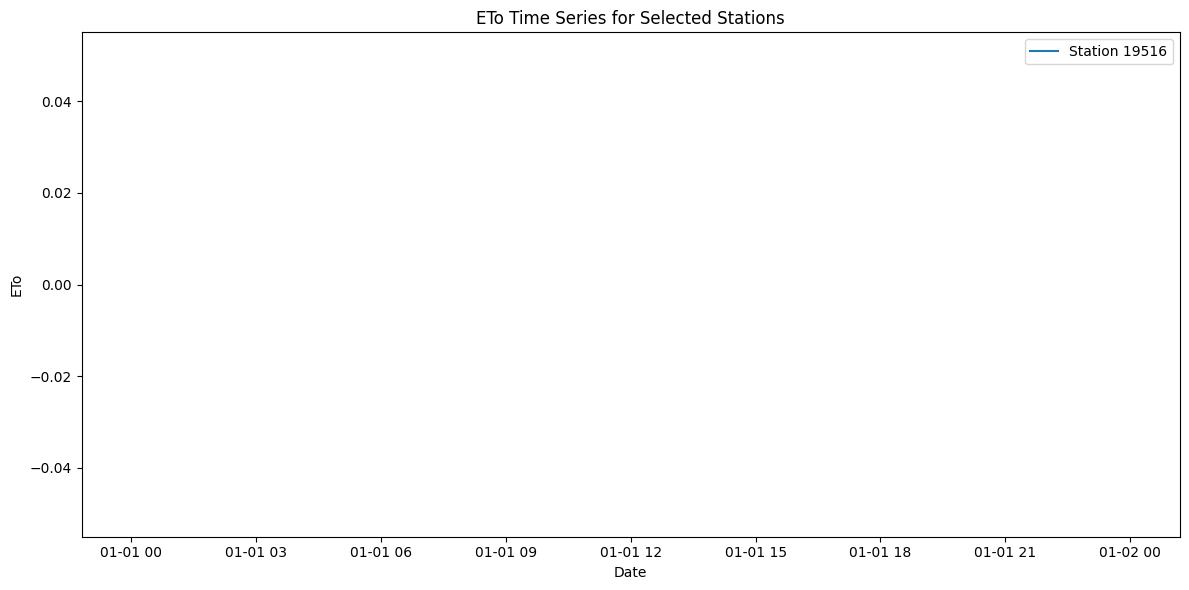

In [13]:
import matplotlib.pyplot as plt

# Select a few station_ids to plot (change as needed)
stations_to_plot = result['station_id'].drop_duplicates().sample(1)

plt.figure(figsize=(12, 6))
for sid in stations_to_plot:
    station_data = result[result['station_id'] == sid].sort_values('date')
    plt.plot(station_data['date'], station_data['FAO-56'], label=f'Station {sid}')

plt.xlabel('Date')
plt.ylabel('ETo')
plt.title('ETo Time Series for Selected Stations')
plt.legend()
plt.tight_layout()
plt.show()

# Change Column Names

In [14]:
result.columns

Index([             'date',        'station_id',      'station_name',
               'region_id',       'region_name',               'lat',
                     'lon', 'station_elevation',              'tmax',
                    'tmin',                'tm',              'umax',
                    'umin',                'um',               'ffm',
                    'sshn',             'rrr24',                   0,
                  'Penman',            'FAO-56',  'Priestley-Taylor',
         'Kimberly-Penman',       'Thom-Oliver',    'Blaney-Criddle',
                   'Hamon',         'Romanenko',           'Linacre',
                   'Haude',              'Turc',      'Jensen-Haise',
       'Mcguinness-Bordne',        'Hargreaves',            'FAO-24',
                   'Abtew',           'Makkink',             'Oudin'],
      dtype='object')

In [15]:
result.rename(
    columns={
        'FAO-56': 'FAO56',
        'Priestley-Taylor': 'PriestleyTaylor',
        'Kimberly-Penman': 'KimberlyPenman',
        'Thom-Oliver': 'ThomOliver',
        'Blaney-Criddle': 'BlaneyCriddle',
        'Jensen-Haise': 'JensenHaise',
        'Mcguinness-Bordne': 'McguinnessBordne',
        'FAO-24': 'FAO24',
    }, 
    inplace=True
)

# Export Data

In [16]:
# To pickle in data folder
with open('../../data/ETo/Khorasan_ETo_Data_1950_2025.pkl', 'wb') as f:
    pickle.dump(result, f)